##### กำหนดค่าพารามิเตอร์ที่จำเป็น 

In [1]:
img_rows = 28
img_cols = 28
num_classes = 10
val_size = 0.2
random_state = 99
batch_size = 128
epochs = 50

input_shape = (img_rows, img_cols, 1)

##### โหลดข้อมูล Dataset

In [2]:
import tensorflow as tf
print(dir(tf.keras.datasets))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'boston_housing', 'cifar10', 'cifar100', 'fashion_mnist', 'imdb', 'mnist', 'reuters']


In [3]:
# Load Dataset
import tensorflow as tf
datasets = tf.keras.datasets.fashion_mnist

(train_data, y), (test_data, y_test) = datasets.load_data()
print('Train - rows:', train_data.shape[0], 'columns:', train_data.shape[1], 'rows:', train_data.shape[2])
print('Test - rows:', test_data.shape[0], 'columns:', test_data.shape[1], 'rows:', test_data.shape[2])

Train - rows: 60000 columns: 28 rows: 28
Test - rows: 10000 columns: 28 rows: 28


##### ใช้ for loop แสดงภาพตตัวอย่าง 9 ภาพ

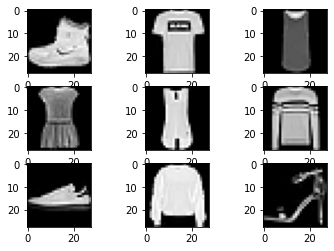

In [4]:
#แสดงภาพตตัวอย่าง 9 ภาพ
import matplotlib.pyplot as plt


for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_data[i], cmap=plt.get_cmap('gray'))

plt.savefig('fashion_mnist.jpeg', dpi=300)

##### ขยายมิติ Dataset 

In [5]:
#ขยายมิติ Dataset 
print(train_data.shape, test_data.shape)

train_data = train_data.reshape((train_data.shape[0], 28, 28, 1))
test_data = test_data.reshape((test_data.shape[0], 28, 28, 1))

print(train_data.shape, test_data.shape)


(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


##### ทำ Scaling

In [6]:
train_data = train_data / 255.0
test_data = test_data / 255.0

##### เข้ารหัสผลเฉลยแบบ one-hot encoding

In [7]:
from keras.utils.np_utils import to_categorical

y = to_categorical(y)
y_test = to_categorical(y_test)

print(y.shape, y_test.shape)
y[:10]

(60000, 10) (10000, 10)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

##### แบ่งข้อมูลสำหรับ train และ validate โดยการสุ่มในสัดส่วน 80:20

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, y, 
                                                    test_size=0.2,
                                                    random_state=99)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

##### นิยามวิธีการทำ Image Augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

##### การสร้างโมเดล

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

#### การ compile โมเดล

In [11]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

##### แสดงโครงสร้างของโมเดลอีกแบบหนึ่ง

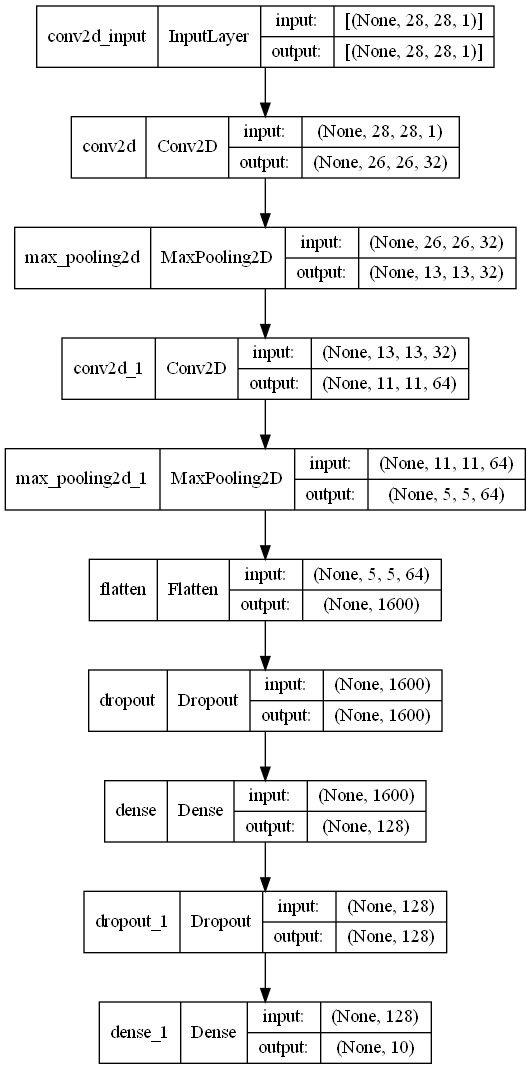

In [12]:
# pip install graphviz
# conda install -c conda-forge pydotplus

from tensorflow.keras.utils import plot_model

plot_model(model, 'digit.png', show_shapes=True, show_layer_names=True)

##### การ train โมเดล

In [13]:
# train the head of the network
history = model.fit(
				datagen.flow(X_train, y_train, batch_size=batch_size),
				steps_per_epoch=len(X_train) // batch_size,
				validation_data=(X_test, y_test),
				validation_steps=len(X_test) // batch_size,
				epochs=epochs)

Epoch 1/50
375/375 [==============================] - 30s 80ms/step - loss: 1.2804 - accuracy: 0.5280 - val_loss: 0.7504 - val_accuracy: 0.7065
Epoch 2/50
375/375 [==============================] - 31s 84ms/step - loss: 0.9259 - accuracy: 0.6567 - val_loss: 0.6478 - val_accuracy: 0.7370
Epoch 3/50
375/375 [==============================] - 33s 88ms/step - loss: 0.8507 - accuracy: 0.6815 - val_loss: 0.6473 - val_accuracy: 0.7313
Epoch 4/50
375/375 [==============================] - 33s 87ms/step - loss: 0.7994 - accuracy: 0.7039 - val_loss: 0.5712 - val_accuracy: 0.7767
Epoch 5/50
375/375 [==============================] - 31s 83ms/step - loss: 0.7702 - accuracy: 0.7124 - val_loss: 0.5606 - val_accuracy: 0.7761
Epoch 6/50
375/375 [==============================] - 31s 82ms/step - loss: 0.7422 - accuracy: 0.7256 - val_loss: 0.5536 - val_accuracy: 0.7775
Epoch 7/50
375/375 [==============================] - 31s 83ms/step - loss: 0.7233 - accuracy: 0.7337 - val_loss: 0.5418 - val_accuracy:

In [14]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: {:.3f}'.format(score[1]))

375/375 [==============================] - 2s 4ms/step - loss: 0.3967 - accuracy: 0.8588
Accuracy: 0.859


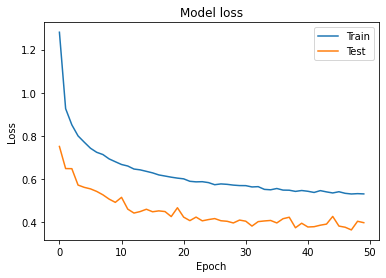

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

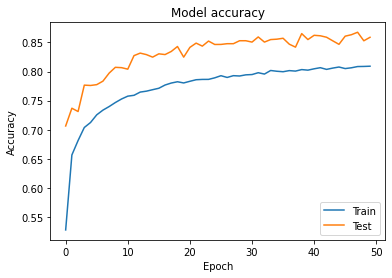

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [17]:
import numpy as np 
import pandas as pd 

y_pred = model.predict(X_test)
y_pred1 = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

##### พยากรณ์เปรียบเทียบระหว่างข้อมูลจริงและข้อมูลพยากรณ์

In [18]:
df = pd.DataFrame({'ข้อมูลจริง': y_test, 'ข้อมูลพยากรณ์': y_pred1})
df 

,ข้อมูลจริง,ข้อมูลพยากรณ์
0,2,2
1,5,5
2,2,2
3,1,1
4,9,9
...,...,...
11995,7,7
11996,2,2
11997,8,8
11998,6,0


##### นับจำนวนข้อมูลในแต่ละ class ด้วย counter 

In [19]:
import collections as cs 
c = cs.Counter(y_test)
c 

Counter({2: 1187,
         5: 1255,
         1: 1200,
         9: 1156,
         8: 1184,
         0: 1195,
         3: 1194,
         6: 1204,
         4: 1211,
         7: 1214})

In [20]:
 class_names = ["T-shirt/top", "Trouser", "Pullover", 
               "Dress", "Coat","Sandal", "Shirt", "Sneaker",
               "Bag", "Ankle boot"]
 class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Accuracy Score: 0.86
              precision    recall  f1-score   support

 T-shirt/top     0.8168    0.8134    0.8151      1195
     Trouser     0.9824    0.9792    0.9808      1200
    Pullover     0.8155    0.8045    0.8100      1187
       Dress     0.8862    0.8476    0.8664      1194
        Coat     0.8352    0.6697    0.7434      1211
      Sandal     0.9238    0.9753    0.9488      1255
       Shirt     0.5597    0.6811    0.6145      1204
     Sneaker     0.9447    0.9003    0.9220      1214
         Bag     0.9357    0.9713    0.9532      1184
  Ankle boot     0.9480    0.9464    0.9472      1156

    accuracy                         0.8588     12000
   macro avg     0.8648    0.8589    0.8601     12000
weighted avg     0.8647    0.8588    0.8600     12000

[[ 972    0   22   32    1    2  145    0   21    0]
 [   0 1175    1   14    0    0    7    0    2    1]
 [   9    0  955    7   56    1  152    0    7    0]
 [  56   14    7 1012   14    3   79    0    9    0]
 [   3  

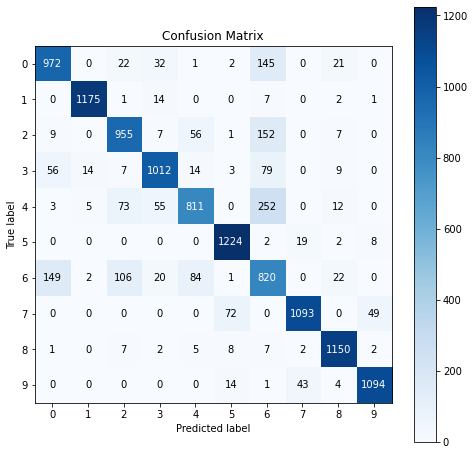

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, y_pred1)))
print(classification_report(y_test, y_pred1, target_names=class_names, digits=4))
cm = confusion_matrix(y_test, y_pred1)
print(cm)

#pip install scikit-plot
import scikitplot as skplot 
plt.rcParams['figure.figsize'] = 8,8
skplot.metrics.plot_confusion_matrix(y_test, y_pred1)
plt.show()

##### การบันทึก model เอาไว้ใช้งาน 

In [22]:
model.save('datamodel.h5')
model.save('datamodel')

INFO:tensorflow:Assets written to: datamodel\assets


##### การโหลด model มาใช้งาน

In [23]:
#my_model.get_config()
from tensorflow.keras.models import load_model
datamodel = load_model('datamodel.h5')

datamodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

##### การนำโมเดลที่บันทึกไว้มา train ใหม่อีกครั้ง 

In [ ]:
history = datamodel.fit(X_train, y_train, 
                    epochs=50, batch_size=10, 
                    verbose=1, validation_split=0.25,
                    shuffle=True) #validation_data=(X_test,y_test)